<a href="https://colab.research.google.com/github/kojiyam/denso/blob/master/jd1_modulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 可聴帯域搬送波のQPSK変調信号

式番号は守倉他『通信方式』

実行: Shift+Enter

In [128]:
# 2021/8/1時点のGoogle Colabでは!pip show ipythonで5.5.0と出て，
# IPython.display.Audio(normalize=False)ができないので，アップデート
# 指示通り"Restart Runtime"必要
!pip install "ipython>=7"

In [129]:
import numpy as np
np.random.seed(1) # 乱数のseedは固定

import matplotlib.pyplot as plt
plt.rcParams["font.size"] = 16
from matplotlib import animation
import IPython.display

## 単純な正弦波（搬送波）を鳴らす方法

In [130]:
# 搬送波のパラメータ
Ac = 0.1
fc = 523 # (Hz) Carrier frequency
sampling_rate = int(10e3) # (Hz) 音として出力するためのサンプリング周波数．変調とは関係なし

$ \mathrm{Re} [ A_\mathrm{c} \mathrm{e}^{\mathrm{j} 2\pi f_\mathrm{c} t} ] = A_\mathrm{c} \cos (2\pi f_\mathrm{c} t)$

In [131]:
T_LENGTH = 10 # 音の時間長 (s)
t = np.arange( T_LENGTH * sampling_rate ) / sampling_rate # サンプリング時刻
# s = np.real( Ac * np.exp( (1j) * 2 * np.pi * fc * t) )
s = Ac * np.cos( 2 * np.pi * fc * t ) # これでも同じ

In [132]:
t

array([0.0000e+00, 1.0000e-04, 2.0000e-04, ..., 9.9997e+00, 9.9998e+00,
       9.9999e+00])

sampling_rate = 10 kHz であれば，サンプリング間隔は100 μs = 10$^{-4}$ s

In [133]:
IPython.display.Audio(s, rate = sampling_rate, normalize=False)

In [134]:
f1 = 523
f2 = 525
# s = (1/2) * ( Ac * np.cos( 2 * np.pi * f1 * t) + Ac * np.cos( 2 * np.pi * f2 * t) )
s = Ac * np.cos( 2 * np.pi * fc * t) * np.cos( 2* np.pi * 1* t)

IPython.display.Audio(s, rate = sampling_rate, normalize=False)

□位相の表示は it1_modulation 参照

## 変調 (QPSK)

`Ts` は，(12.1)などではシンボル長 $T$

In [135]:
N = 10  # Number of symbols
Ts = 1 # Symbol length (s/symbol)

#N = 100  # Number of symbols
#Ts = 0.1 # Symbol length (s/symbol)


`B` は (12.9) $ (b_{nM},b_{nM+1},\dots,b_{(n+1)M-1} ) $

$M$ は1シンボルあたりのビット数．ここではQPSKのため，$M=2$



In [136]:
B = np.random.randint(0, 4, N) # 2 bitを表す [0,3] の一様乱数N個．ビット系列 bit sequence

Text(0, 0.5, '$(b_{2n+1},b_{2n})$')

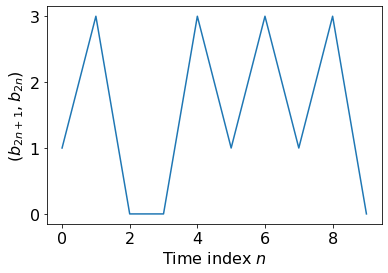

In [137]:
plt.plot(B, label='$(b_{2n+1},b_{2n})$')
plt.yticks(np.arange(0, 3 + 1, 1))
plt.xlabel(r'Time index $n$')
plt.ylabel(r'$(b_{2n+1},b_{2n})$')
#plt.legend(loc='upper right')

縦軸は $ B_n := 2 b_{n+1} + b_{2n} $

例えば，縦軸が2であれば $(b_{2n+1},b_{2n})=(1,0)$


`A` は (12.9) に関連して，$ a_n = \exp(\mathrm{j} \pi (1+2 B_n)/4)$

In [138]:
A = np.exp(1j * (1/4 + B/2) * np.pi) # QPSK

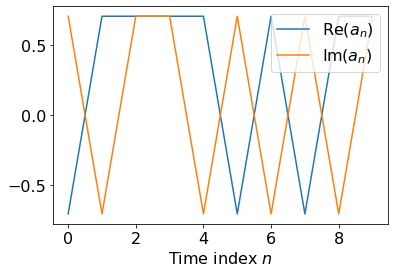

In [139]:
plt.plot(A.real, label='$\mathrm{Re}(a_n)$')
plt.plot(A.imag, label='$\mathrm{Im}(a_n)$')
plt.xlabel('Time index $n$')
plt.legend(loc='upper right')

(離散時間)系列から，(連続時間)信号に

In [140]:
# Rectangular pulse filter
# b = np.repeat(sQ,Ts*Fs)

(12.10) $ \displaystyle x(t) = \sum_{n=-\infty}^\infty a_n \, \delta(t-nT) $

(12.12) $ \delta(t) = \begin{cases} 1, & 0 \leq t < T \\ 0, & \text{otherwise} \end{cases}$

$\delta(t)$は，デルタ関数ではない

ここでは上記の代わりに，ルート2乗余弦フィルタ（Root raised cosine filter, 『通信方式』11.5節 ）を使う

まず，インパルス系列を作り，その後でルート2乗余弦フィルタのインパルス応答とたたみ込む．

インパルス系列は，(12.10)の $\delta(t)$ として，デルタ関数を用いたものに相当する．ただし，サンプリングしているので，以下のようにした(12.10)の $x(t)$ を $x_0(t)$ としている．

$ \delta(t) = \begin{cases} 1, & t=0 \\ 0, & \text{otherwise} \end{cases}$

In [141]:
# x0はA[0], 0, ..., 0, A[1], 0, ..., 0, A[2] という系列
x0 = np.ravel( np.concatenate([np.reshape(A,(N,1)), np.zeros([N,sampling_rate*Ts-1]) ], axis=1) )
t = np.arange(N*sampling_rate)/sampling_rate

In [142]:
# x0は以下でも作ることができる
# x0 = np.empty(0)
# for i in range(N):
#    x0 = np.concatenate([x, np.atleast_1d(A[i]), np.zeros(sampling_rate*Ts-1)])

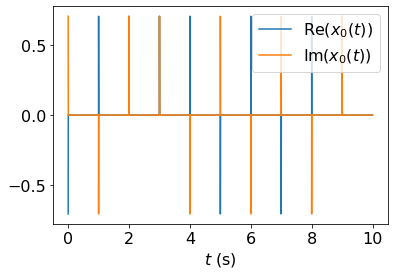

In [143]:
plt.plot(t, x0.real, label='$ \mathrm{Re} (x_0(t)) $')
plt.plot(t, x0.imag, label='$ \mathrm{Im} (x_0(t)) $')
plt.xlabel('$t$ (s)')
plt.legend(loc='upper right')

横軸は時間に変わっていることに注意

『通信方式』11.5節 ルート2乗余弦フィルタ（Root raised cosine filter） 

In [144]:
## Root raised cosine filter のためのライブラリ
## https://commpy.readthedocs.io/en/latest/generated/commpy.filters.rrcosfilter.html
!pip install scikit-commpy
from commpy.filters import rrcosfilter

In [145]:
# フィルタのインパルス応答を生成
# ここでは，前後6シンボル分の波形に限定（パルステイル打ち切り．p.111）
# ロールオフファクタ alpha=0.8
t0, h_RRC = rrcosfilter(Ts*sampling_rate*6, 0.8, Ts, sampling_rate)

Text(0, 0.5, '$ h_\\mathrm{RRC}(t)$')

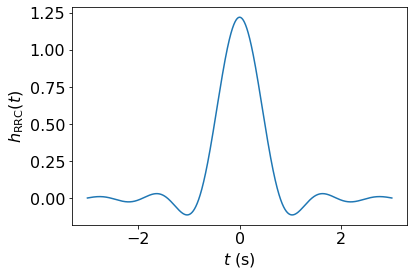

In [146]:
# フィルタのインパルス応答
plt.plot(t0,h_RRC)
plt.xlabel('$t$ (s)')
plt.ylabel('$ h_\mathrm{RRC}(t)$')

フィルタの前後分時間が増えるので，`t` とは別に `t2` を作る

以下の `x` が，(12.10) でルート2乗余弦フィルタを適用した場合の $x(t)$

In [147]:
# ベースバンド信号（インパルス応答h_RRCとインパルス列x0の畳み込み）
x = np.convolve(h_RRC, x0) # Waveform with PSF
t2 = np.arange(x.size)/sampling_rate

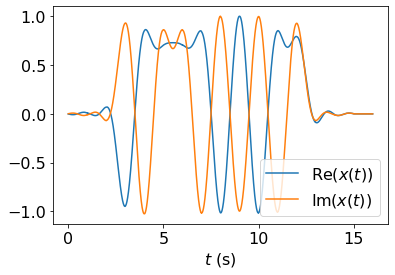

In [148]:
plt.plot(t2, x.real, label='$\mathrm{Re}(x(t))$')
plt.plot(t2, x.imag, label='$\mathrm{Im}(x(t))$')
#plt.plot(t2, np.abs(x), label='$|x(t)|$')
plt.xlabel('$t$ (s)')
plt.legend(loc='lower right')

https://stackoverflow.com/questions/14614966/easy-way-to-implement-a-root-raised-cosine-rrc-filter-using-python-numpy

In [177]:
Z = 1000 # 動画のための間引き
x.size, int(x.size/Z)

(159999, 159)

$ x(t) $ の複素平面上での様子

In [150]:
# 動画のインターバル．fpsの逆数
#INTERVAL = 50 # (ms) 50 ms だと20 fps
INTERVAL = int(1000*Z/sampling_rate)

In [151]:
fig, ax = plt.subplots()
plt.close()
ax.set_xlim((-1.5, 1.5))
ax.set_ylim((-1.5, 1.5))
ax.set_yticks(np.arange(-1, 1 + 1, 1))
ax.set_aspect('equal')
line1, = ax.plot([], [], lw=5)
def animate(i):
  line1.set_data(x.real[i*Z:i*Z+Z], x.imag[i*Z:i*Z+Z])
anim = animation.FuncAnimation(fig, animate, frames=150, interval=INTERVAL, blit=False)
IPython.display.HTML(anim.to_jshtml())

In [152]:
# 搬送波のパラメータ
Ac = 0.1
fc = 523 # (Hz) Carrier frequency

(12.11) $ s(t) = \mathrm{Re} [ A_\mathrm{c} \mathrm{e}^{\mathrm{j} 2\pi f_\mathrm{c} t} x(t) ] $ 実信号

$A_\mathrm{c} \mathrm{e}^{\mathrm{j} 2\pi f_\mathrm{c} t} x(t)$ 解析的信号（asnalytical signal）[三上2005]では解析信号(analytic signal)を，「負の周波数成分を持たない信号」として定義してある

$ A_\mathrm{c} x(t) $ 直交成分

$ \mathrm{e}^{\mathrm{j} 2\pi f_\mathrm{c} t} $ 複素搬送波

 [神谷2008] での呼び方

In [153]:
s = np.real( Ac * np.exp( (1j) * 2 * np.pi * fc * t2) * x )

In [154]:
IPython.display.Audio(s, rate = sampling_rate, normalize=False)

Text(0, 0.5, '$s(t)$')

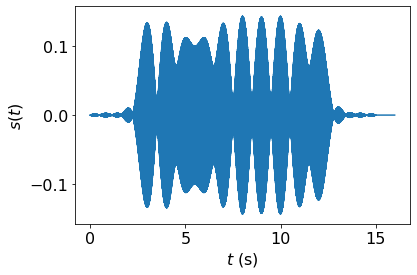

In [155]:
plt.plot(t2, s)
plt.xlabel('$t$ (s)')
plt.ylabel('$s(t)$')

Text(0, 0.5, '$s(t)$')

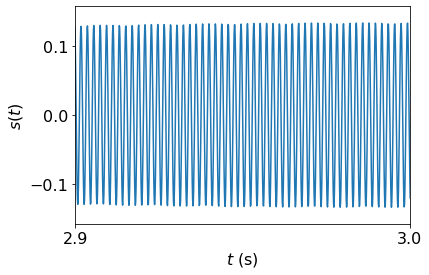

In [156]:
# 横軸を拡大
plt.plot(t2, s)
plt.xlim(2.9,3)
plt.xticks(np.arange(2.9, 3.0, 0.1))
plt.xlabel('$t$ (s)')
plt.ylabel('$s(t)$')

# 受信

(13.1)で，伝送路のインパルス応答$g(t)$としてデルタ関数を仮定した(13.29)において，更に$a_0=1$，$\tau_0=0$とすると

$ y(t) = s(t) + n(t) $ となる

$ n(t) $はガウス雑音とする

In [157]:
n = 2.*np.random.normal(loc=0.0, scale=np.sqrt(1/2), size=s.size)
y = s + n

In [158]:
# np.max(abs(y)で割って0.1をかけているのは，最大振幅1（IPython.display.Audioの仕様）にした上で，うるさいので音量を0.1倍にしている
IPython.display.Audio(0.1*y/np.max(abs(y)), rate = sampling_rate, normalize=False)

Text(0, 0.5, '$y(t)$')

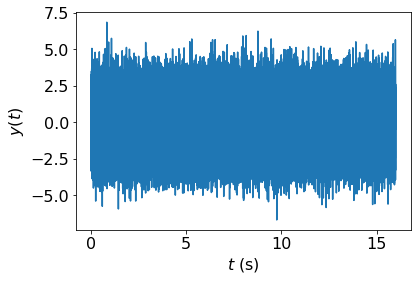

In [159]:
plt.plot(t2, y)
#plt.xlim(2.9,3)
#plt.xticks(np.arange(2.9, 3.0, 0.1))
plt.xlabel('$t$ (s)')
plt.ylabel('$y(t)$')

In [160]:
# 単純移動平均だと以下でできる
# num=1000; b=np.ones(num)/num
# y2 = np.convolve(y * np.exp( (-1j) * 2 * np.pi * fc * t2), b, mode='same')

(13.30)--(13.32)の同期検波を行う

$ \bar{f}_\mathrm{c}=f_\mathrm{c} $，$ \phi=0 $の場合を考える

$ \zeta_\mathrm{R}(t) - \mathrm{j} \zeta_\mathrm{I}(t)= y(t) \cdot \mathrm{e}^{-\mathrm{j} 2\pi f_\mathrm{c}t} $ と書ける

LPFとして，送信フィルタと同じくルート2乗余弦フィルタを使えば，整合フィルタの条件を満たす．この出力を$\zeta(t)$とする

ルート2乗余弦フィルタを通すということは，時系列で言えば，$y(t)$とルート2乗余弦フィルタのインパルス応答をたたみ込むということである．

In [161]:
# 整合フィルタ出力
zeta = np.convolve( y * np.exp( (-1j) * 2 * np.pi * fc * t2), h_RRC, mode='same' )
# 絶対値を何とかしたい

Text(0, 0.5, '$\\zeta(t)$')

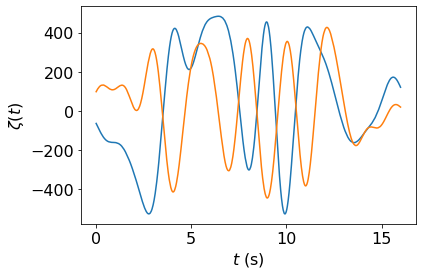

In [162]:
plt.plot(t2, np.real(zeta))
plt.plot(t2, np.imag(zeta))
plt.xlabel('$t$ (s)')
plt.ylabel('$\zeta(t)$')

In [180]:
fig, ax = plt.subplots()
plt.close()
W = 600
ax.set_xlim((-W, W))
ax.set_ylim((-W, W))
#ax.set_yticks(np.arange(-1, 1 + 1, 1))
ax.set_aspect('equal')
line1, = ax.plot([], [], '.', lw=0)
def animate(i):
  line1.set_data(zeta.real[i*Z:i*Z+Z], zeta.imag[i*Z:i*Z+Z])
anim = animation.FuncAnimation(fig, animate, frames=150, interval=INTERVAL, blit=False)
IPython.display.HTML(anim.to_jshtml())

これを妥当なタイミングでサンプルして，元の系列に戻す

## フーリエ変換（講義では省略）

In [166]:
S = np.fft.fft(s)
Y = np.fft.fft(y)
Z = np.fft.fft(zeta)

In [167]:
freq = np.fft.fftfreq(s.size, d=1/sampling_rate)

In [168]:
S_power = np.abs(S/(S.size/2))**2
Y_power = np.abs(Y/(Y.size/2))**2
Z_power = np.abs(Z/(Z.size/2))**2

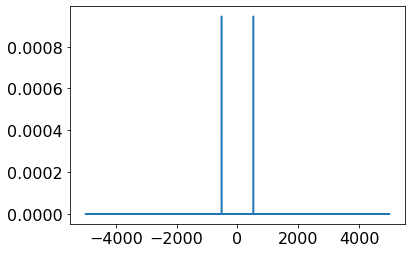

In [169]:
plt.plot(freq, S_power)

Text(0.5, 0, '$f$ (Hz)')

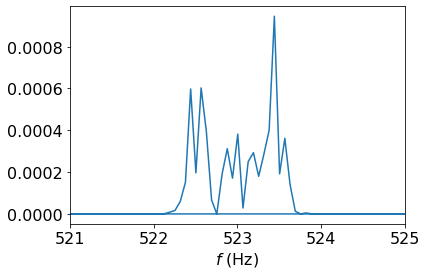

In [170]:
plt.plot(freq, S_power)
plt.xlim(521,525)
plt.xlabel('$f$ (Hz)')

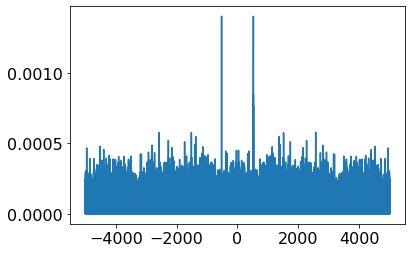

In [171]:
plt.plot(freq, Y_power)

Text(0.5, 0, '$f$ (Hz)')

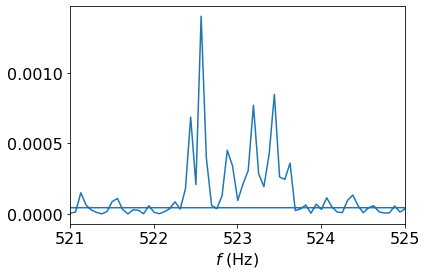

In [172]:
plt.plot(freq, Y_power)
plt.xlim(521,525)
plt.xlabel('$f$ (Hz)')

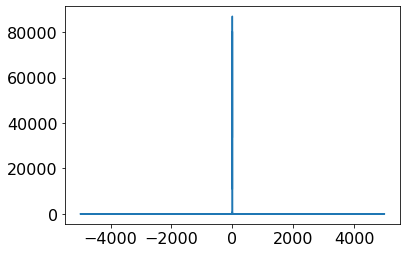

In [173]:
plt.plot(freq, Z_power)

Text(0.5, 0, '$f$ (Hz)')

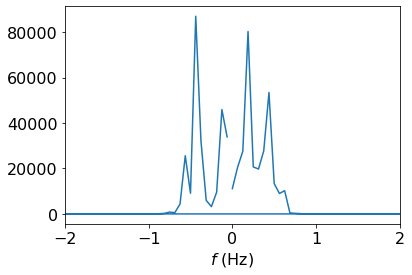

In [174]:
plt.plot(freq, Z_power)
plt.xlim(-2,2)
plt.xlabel('$f$ (Hz)')

## ベースバンド信号のスペクトラム

Text(0.5, 0, '$f$ (Hz)')

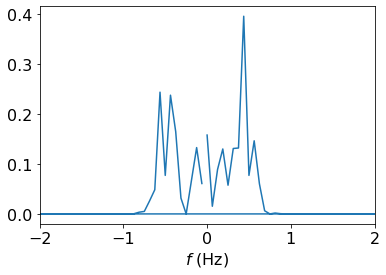

In [175]:
X = np.fft.fft(x)
freq2 = np.fft.fftfreq(x.size, d=1/sampling_rate)
plt.plot(freq2, np.abs(X/(X.size/2))**2)
plt.xlim(-2,2)
plt.xlabel(r'$f$ (Hz)')

FFT 参考

https://helve-python.hatenablog.jp/entry/2018/06/17/000000

[三上2005] 三上, はじめて学ぶディジタル・フィルタと高速フーリエ変換, CQ出版, 2005.

[神谷2008] 神谷, MATLABによるディジタル無線通信技術, コロナ社, 2008.